# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [1]:
!pip install unrar

In [2]:
!pip install patool
import patoolib

     |████████████████████████████████| 77 kB 4.0 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/Acv')

In [5]:
!ls

ACv.csv        images_racoon.rar
images_racoon  R10_Internal_Lab_Question_Notebook.ipynb


In [6]:
#patoolib.extract_archive('images_racoon.rar')
#Since i have extracted and uploaded the folder i do not need to run this code

In [7]:
len(os.listdir('/content/drive/MyDrive/Acv/images_racoon/images'))

200

### Import the necessary libraries

In [8]:
import cv2
import numpy as np
import pandas as pd
np.random.seed(1)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import csv

In [9]:
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import RepeatVector,Conv1D,Flatten,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.backend import epsilon
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from keras.applications.resnet50 import ResNet50,preprocess_input

### Mount to drive

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')
#Already mounted earlier

### Change directory

In [11]:
#Already changed
#import os
#os.chdir('/content/drive/MyDrive/Acv')

In [12]:
!ls

ACv.csv        images_racoon.rar
images_racoon  R10_Internal_Lab_Question_Notebook.ipynb


### Load the training data from train.csv file

In [13]:
df = pd.read_csv('/content/drive/MyDrive/Acv/ACv.csv')

### Print the shape of the train dataset

In [14]:
df.shape

(173, 8)

In [15]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [16]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width and height, x0, y0, x1, y1 in individual variables. <br>
1. Create a list variable known as 'paths' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be resized to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [43]:
paths = []
coords = np.zeros((len(df), 4))

coords = np.zeros((len(df), 4))
for index, row in df.iterrows():
  filename = row['filename']
  paths.append(os.path.join(os.getcwd(),"/content/drive/MyDrive/Acv/images_racoon/images" , filename ))

  coords[index][0] = row['xmin'] * IMAGE_SIZE / row['width']
  coords[index][1] = row['ymin'] * IMAGE_SIZE / row['height']
  coords[index][2] = row['xmax'] * IMAGE_SIZE / row['width']
  coords[index][3] = row['ymax'] * IMAGE_SIZE / row['height']

In [44]:
len(paths)

173

In [45]:
coords[0]

array([46.94980695, 39.58762887, 82.53281853, 77.8556701 ])

In [46]:
print(paths)

['/content/drive/MyDrive/Acv/images_racoon/images/raccoon-17.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-11.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-63.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-63.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-60.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-69.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-180.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-200.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-141.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-19.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-84.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-124.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-182.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-111.jpg', '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-91.jpg', '/c

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [47]:
import tensorflow as tf 
from tensorflow.keras.applications.mobilenet import preprocess_input

In [48]:
for i ,image in enumerate(paths):
  print(i,image)

0 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-17.jpg
1 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-11.jpg
2 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-63.jpg
3 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-63.jpg
4 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-60.jpg
5 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-69.jpg
6 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-180.jpg
7 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-200.jpg
8 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-141.jpg
9 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-19.jpg
10 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-84.jpg
11 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-124.jpg
12 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-182.jpg
13 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-111.jpg
14 /content/drive/MyDrive/Acv/images_racoon/images/raccoon-91.jpg
15 /content/dr

In [49]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3))
for i , image in enumerate(paths):
  img = Image.open(image)
  ## Resize 
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))

  ## Convert to RGB
  img = img.convert('RGB')

  ## preprocess_input for mobilenet
  batch_images[i] = preprocess_input(np.array(img))

In [50]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3.
### Freeze all the layers and Add convolution layers and reshape layers at the end to ensure the output has 4 coordinates.

In [51]:
ALPHA = 1.0

In [52]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

17235968/17225924 [==============================] - 0s 0us/step


## Plot the model and view the whole skeleton using plot_model.

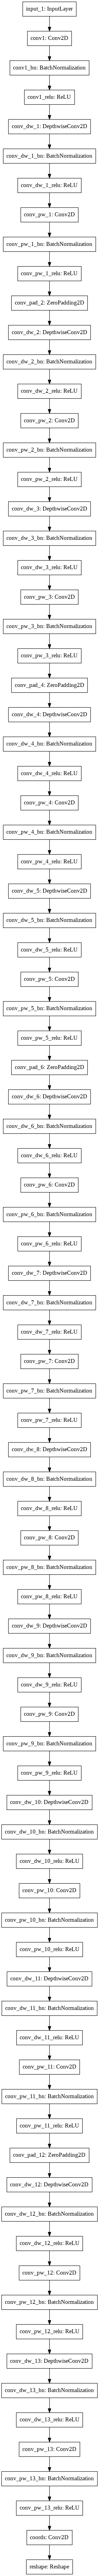

In [53]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

### Define a custom loss function IoU which calculates Intersection Over Union

In [58]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [59]:
gt = coords
len(batch_images)
print(len(coords))
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE
model.fit(batch_images,gt, epochs=30,batch_size = 32, verbose=1)

173
Epoch 1/30
6/6 [==============================] - 37s 120ms/step - loss: 4632.7512 - IoU: 0.0574
Epoch 2/30
6/6 [==============================] - 0s 60ms/step - loss: 897.7295 - IoU: 0.3777
Epoch 3/30
6/6 [==============================] - 0s 60ms/step - loss: 434.1405 - IoU: 0.5727
Epoch 4/30
6/6 [==============================] - 0s 59ms/step - loss: 637.9791 - IoU: 0.5329
Epoch 5/30
6/6 [==============================] - 0s 61ms/step - loss: 353.9866 - IoU: 0.6214
Epoch 6/30
6/6 [==============================] - 0s 60ms/step - loss: 176.8303 - IoU: 0.6739
Epoch 7/30
6/6 [==============================] - 0s 65ms/step - loss: 199.7073 - IoU: 0.6502
Epoch 8/30
6/6 [==============================] - 0s 66ms/step - loss: 151.5483 - IoU: 0.6950
Epoch 9/30
6/6 [==============================] - 0s 68ms/step - loss: 110.4653 - IoU: 0.7543
Epoch 10/30
6/6 [==============================] - 0s 67ms/step - loss: 115.1332 - IoU: 0.7618
Epoch 11/30
6/6 [==============================] - 0

### Pick a test image from the given data

In [70]:
filename = '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-4.jpg'
#test_image = cv2.imread(filename)
img = Image.open(filename)
  ## Resize 
test_img_resize = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  ## Convert to RGB
test_img_RGB = test_img_resize.convert('RGB')
  ## preprocess_input for mobilenet
test_img   = preprocess_input(np.array(test_img_RGB))

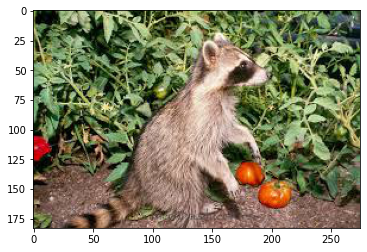

In [71]:
plt.imshow(img)

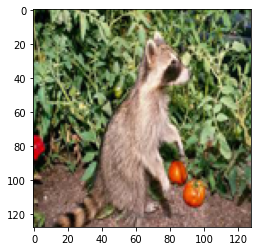

In [74]:
plt.imshow(test_img_resize)

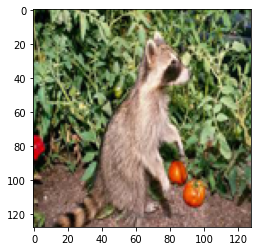

In [75]:
plt.imshow(test_img_RGB)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [76]:
#Already done earlier in previous step.

### Predict the coordinates of the bounding box for the given test image

In [77]:
region = model.predict(np.expand_dims(test_img , axis = 0))[0]

In [78]:
region

array([  9.886684,   8.943359,  94.91922 , 127.43696 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [79]:
unscaled = img

In [80]:
image_width = img.size[0]
image_height = img.size[1]

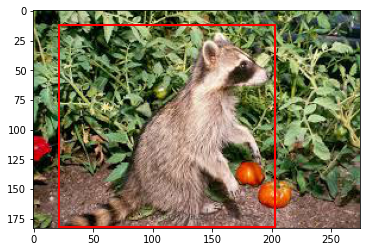

In [81]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# VGG16 Implementation

# VGG 16 Implementation
### Define a variable Image_size which takes accurate input according to the VGG16 model. 

In [82]:
IMAGE_SIZE = 224

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 224 * 224 

In [83]:
paths = []
coords = np.zeros((len(df), 4))

coords = np.zeros((len(df), 4))
for index, row in df.iterrows():
  filename = row['filename']
  paths.append(os.path.join(os.getcwd(),"/content/drive/MyDrive/Acv/images_racoon/images" , filename ))

  coords[index][0] = row['xmin'] * IMAGE_SIZE / row['width']
  coords[index][1] = row['ymin'] * IMAGE_SIZE / row['height']
  coords[index][2] = row['xmax'] * IMAGE_SIZE / row['width']
  coords[index][3] = row['ymax'] * IMAGE_SIZE / row['height']

In [84]:
len(paths)

173

In [85]:
coords[0]

array([ 82.16216216,  69.27835052, 144.43243243, 136.24742268])

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the VGG16 accepts 3 channels as inputs   

In [86]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [87]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3))
for i , image in enumerate(paths):
  img = Image.open(image)
  ## Resize 
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))

  ## Convert to RGB
  img = img.convert('RGB')
  
  ## preprocess_input for mobilenet
  batch_images[i] = preprocess_input(np.array(img))

In [88]:
batch_images.shape

(173, 224, 224, 3)

In [89]:
batch_images[0]

array([[[ -28.93900299,  -29.77899933,  -59.68000031],
        [  -7.93900299,   -9.77899933,  -37.68000031],
        [ -90.93900299,  -91.77899933, -117.68000031],
        ...,
        [  41.06099701,   62.22100067,    1.31999969],
        [  82.06099701,  101.22100067,   42.31999969],
        [  75.06099701,  100.22100067,   41.31999969]],

       [[  -7.93900299,   -8.77899933,  -37.68000031],
        [ -24.93900299,  -26.77899933,  -53.68000031],
        [-101.93900299, -108.77899933, -122.68000031],
        ...,
        [  50.06099701,   72.22100067,   14.31999969],
        [  67.06099701,   85.22100067,   31.31999969],
        [  60.06099701,   80.22100067,   25.31999969]],

       [[   1.06099701,   -0.77899933,  -28.68000031],
        [ -46.93900299,  -49.77899933,  -73.68000031],
        [-103.93900299, -114.77899933, -123.68000031],
        ...,
        [  31.06099701,   58.22100067,    1.31999969],
        [  48.06099701,   65.22100067,   13.31999969],
        [  56.06099701

### Define a vgg16 model and plot the model using plot_model function.
Hint:- Use RepeatVector,Conv1D,GlobalAveragePooling2D(optional to learner)

In [90]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D , Reshape, Flatten

vgg_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in vgg_model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = vgg_model.layers[-1].output
x = Conv2D(4, kernel_size=7)(x)

# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Flatten()(x) # These are the 4 predicted coordinates of one BBox

vgg_model = Model(inputs=vgg_model.input, outputs=x)

58892288/58889256 [==============================] - 1s 0us/step


In [91]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Plot the Vgg16 model using plot_model function.

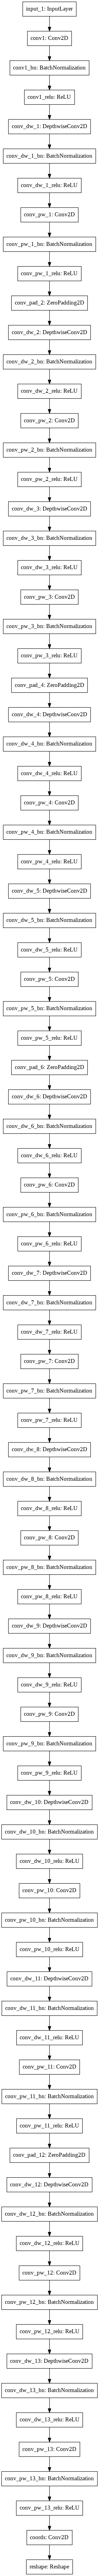

In [92]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [93]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

vgg_model.compile(optimizer= 'adam' , loss = 'mse' , metrics = [IoU])
vgg_model.fit(batch_images , coords, epochs = 10 , batch_size= 32, verbose =1 ,callbacks=[tensorboard_callback])

Epoch 1/10
6/6 [==============================] - 11s 818ms/step - loss: 7328.3135 - IoU: 0.2819
Epoch 2/10
6/6 [==============================] - 1s 148ms/step - loss: 3797.8533 - IoU: 0.4352
Epoch 3/10
6/6 [==============================] - 1s 147ms/step - loss: 2532.9368 - IoU: 0.3785
Epoch 4/10
6/6 [==============================] - 1s 147ms/step - loss: 1383.1730 - IoU: 0.5131
Epoch 5/10
6/6 [==============================] - 1s 152ms/step - loss: 1054.0984 - IoU: 0.5703
Epoch 6/10
6/6 [==============================] - 1s 150ms/step - loss: 747.4765 - IoU: 0.5936
Epoch 7/10
6/6 [==============================] - 1s 150ms/step - loss: 584.8143 - IoU: 0.6679
Epoch 8/10
6/6 [==============================] - 1s 151ms/step - loss: 488.6496 - IoU: 0.7016
Epoch 9/10
6/6 [==============================] - 1s 150ms/step - loss: 377.7680 - IoU: 0.7217
Epoch 10/10
6/6 [==============================] - 1s 149ms/step - loss: 320.2052 - IoU: 0.7243


### Pick a test image from the given data

In [95]:
filename = '/content/drive/MyDrive/Acv/images_racoon/images/raccoon-4.jpg'
#test_image = cv2.imread(filename)
img = Image.open(filename)
  ## Resize 
test_img_resize = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  ## Convert to RGB
test_img_RGB = test_img_resize.convert('RGB')
  ## preprocess_input for mobilenet
test_img   = preprocess_input(np.array(test_img_RGB))

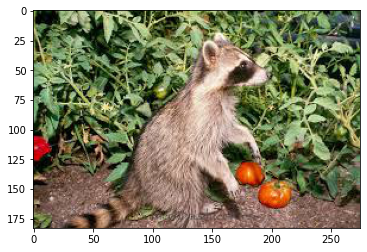

In [96]:
plt.imshow(img)

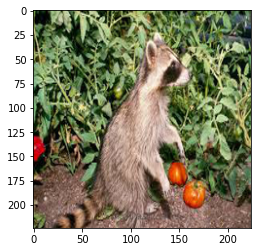

In [97]:
plt.imshow(test_img_resize)

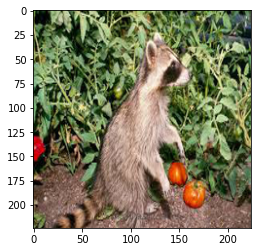

In [98]:
plt.imshow(test_img_RGB)

### Resize the image to 224 * 224 and preprocess the image for the VGG16

In [99]:
#Already done in previous steps

### Predict the coordinates of the bounding box for the given test image

In [100]:
region = vgg_model.predict(np.expand_dims(test_img , axis = 0))[0]

In [101]:
region

array([ 27.68347  ,   3.3502424, 154.63538  , 229.18646  ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [102]:
unscaled = img

In [103]:
image_width = img.size[0]
image_height = img.size[1]

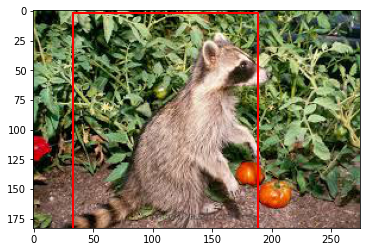

In [104]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### Visualizing model details in tensorboard

In [105]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [106]:
%tensorboard -- logdir logs/fit/

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2021-08-08 16:27:02.927410: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_

In [107]:
!tensorboard dev upload \
  --logdir logs/fit \
  --name "(optional) My latest experiment" \
  --description "(optional) Simple comparison of several hyperparameters" \
  --one_shot

2021-08-08 16:27:20.281175: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs/fit

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&